# KNN and SVD recommender systems for the Jester dataset by Elza Dabola.

In [33]:
# importing needed packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random

from scipy.sparse import csr_matrix 
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity # cosine distance
from sklearn.metrics.pairwise import euclidean_distances # euclidean distance

In [34]:
# reading the datasets and merging them into one
df_items = pd.read_csv("jester_items.csv")
df_users = pd.read_csv('jester_ratings.csv')

df = pd.merge(df_items, df_users, on='jokeId', how='outer')

# Set the display format for float values
pd.set_option('display.float_format', '{:.2f}'.format)

## Data cleaning

In [35]:
# checking for nulls
df.isna().sum()

jokeId       0
jokeText     0
userId      10
rating      10
dtype: int64

Since there are only 10 nulls in userID and rating these will be dropped.

In [36]:
# droping the nulls
df.dropna(inplace=True)

In [37]:
# checking for nulls 
a = df.isna().any()

if a.any():
    print('there are missing values')
else:
    print('there are no missing values')

there are no missing values


In [38]:
# checking the types 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761439 entries, 4 to 1761448
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   jokeId    int64  
 1   jokeText  object 
 2   userId    float64
 3   rating    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 67.2+ MB


There are a couple of float types, let's check how the data looks before tranforming the types

In [39]:
df.head()

,jokeId,jokeText,userId,rating
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...,1.00,0.22
5,5,Q.\tWhat's O. J. Simpson's Internet address? \...,2.00,-9.69
6,5,Q.\tWhat's O. J. Simpson's Internet address? \...,3.00,-9.84
7,5,Q.\tWhat's O. J. Simpson's Internet address? \...,4.00,-5.81
8,5,Q.\tWhat's O. J. Simpson's Internet address? \...,5.00,6.91


UserId, of course, is a discrete variable, which will be transformed into an integer. However, the ratings are continuous, so their type won't be changed. 

In [40]:
# changing the userId type to int
 
df['userId'] = df['userId'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761439 entries, 4 to 1761448
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   jokeId    int64  
 1   jokeText  object 
 2   userId    int32  
 3   rating    float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 60.5+ MB


In [41]:
# checking the range of ratings
print('the min rating in the dataset is', df['rating'].min())
print('the max rating in the dataset is', df['rating'].max())

the min rating in the dataset is -10.0
the max rating in the dataset is 10.0


## EDA

In [42]:
# checking how the data looks
df.describe()

,jokeId,userId,rating
count,1761439.00,1761439.00,1761439.00
mean,70.71,32723.22,1.62
std,46.01,18280.11,5.30
min,5.00,1.00,-10.00
25%,21.00,17202.00,-2.03
50%,69.00,34808.00,2.22
75%,112.00,47306.00,5.72
max,150.00,63978.00,10.00


In [43]:
# checking the nr unique users and items, code inspired from https://www.kaggle.com/code/razor08/knn-based-collaborative-filtering?scriptVersionId=81850169 
nr_users = len(df.userId.unique())
nr_items = len(df.jokeId.unique())

print('there are {} unique users and {} unique jokes'.format(nr_users, nr_items))

there are 59132 unique users and 140 unique jokes


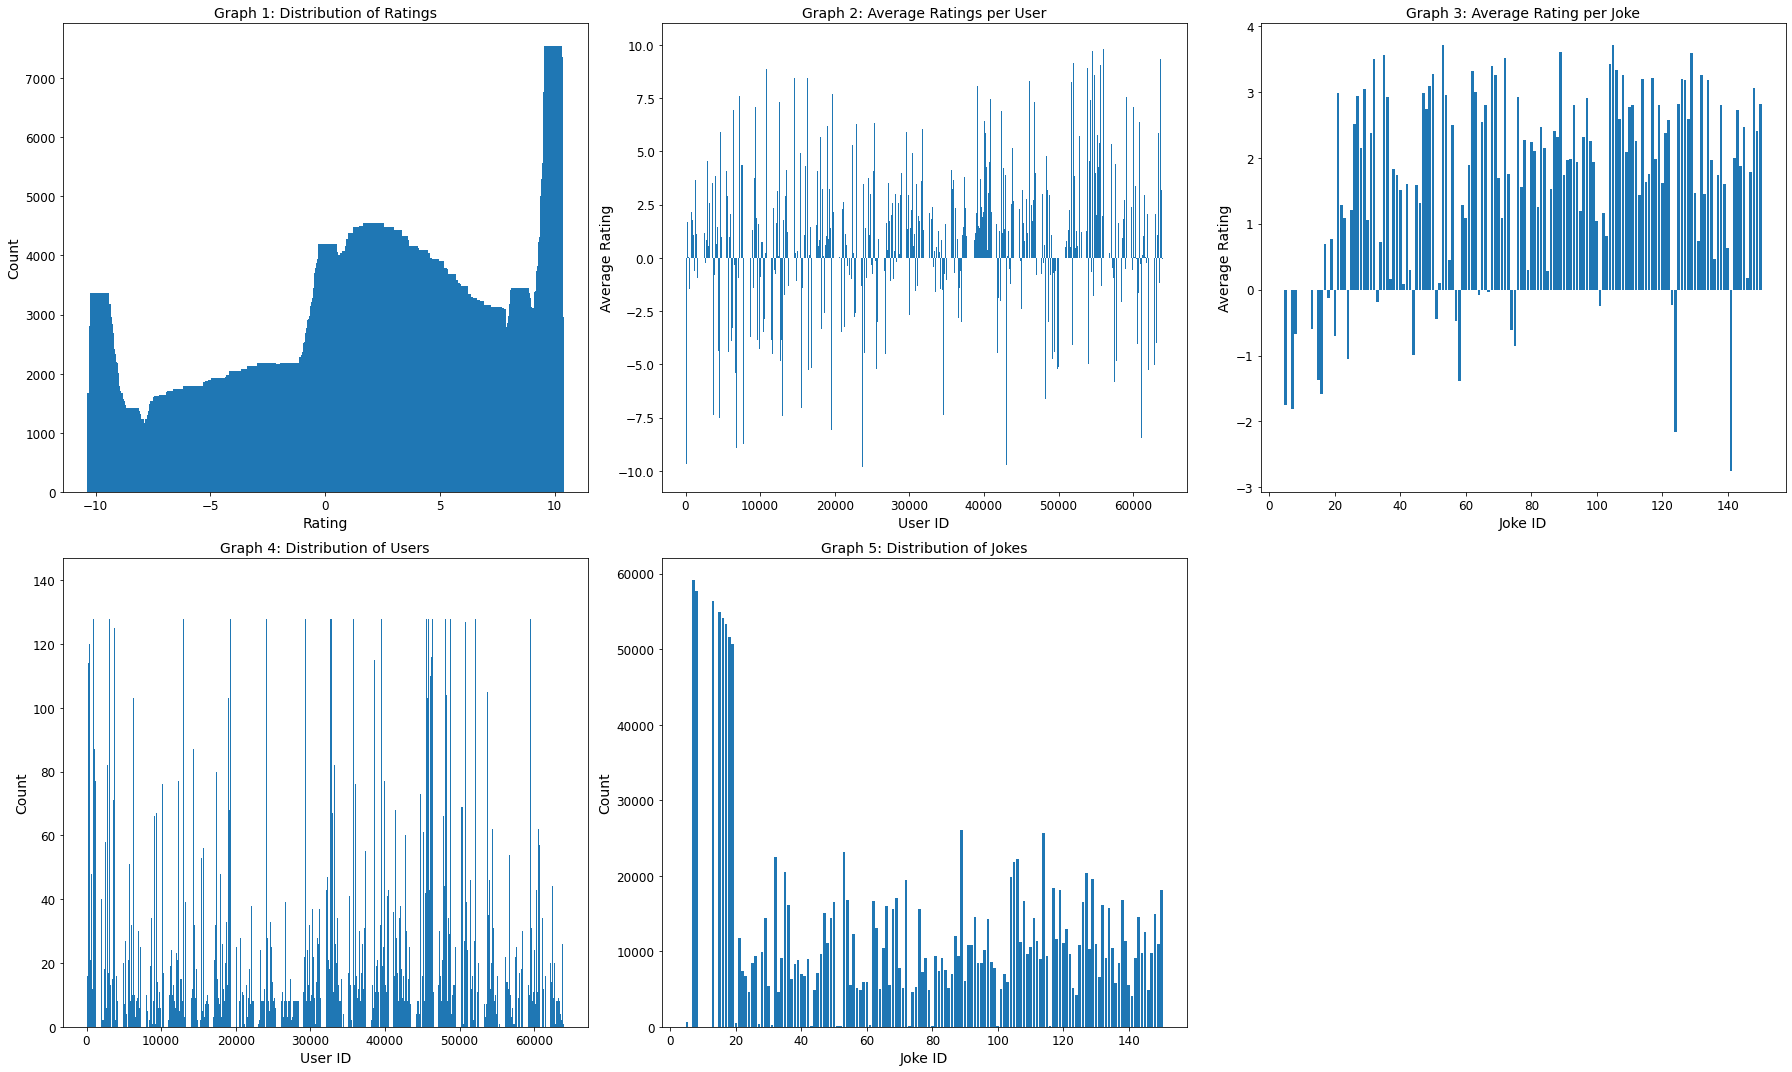

In [44]:
## getting some initial insights into the data through visualisations 

# creating dataframes / variables for the graphs
rating_count = pd.DataFrame(df.groupby('rating').size(), columns=['count'])
joke_count = pd.DataFrame(df.groupby('jokeId').size(), columns=['count'])
user_count = pd.DataFrame(df.groupby('userId').size(), columns=['count'])
avg_rating_per_userid = df.groupby('userId')['rating'].mean()
avg_rating_per_jokeid = df.groupby('jokeId')['rating'].mean()

# creating figures and gridspec
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(2, 3, figure=fig)

# plotting the distribution of ratings
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(x=rating_count.index, height=rating_count['count'])
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')
ax1.set_title('Graph 1: Distribution of Ratings')

# plotting the distribution of average ratings per user
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(avg_rating_per_userid.index, avg_rating_per_userid)
ax2.set_xlabel('User ID')
ax2.set_ylabel('Average Rating')
ax2.set_title('Graph 2: Average Ratings per User')

# plotting the distribution of average rating per joke
ax3 = fig.add_subplot(gs[0,2])
ax3.bar(avg_rating_per_jokeid.index, avg_rating_per_jokeid)
ax3.set_xlabel('Joke ID')
ax3.set_ylabel('Average Rating')
ax3.set_title('Graph 3: Average Rating per Joke')

# plotting the distribution of users
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(x=user_count.index, height=user_count['count'])
ax4.set_xlabel('User ID')
ax4.set_ylabel('Count')
ax4.set_title('Graph 4: Distribution of Users')

# plotting the distribution of jokes
ax5 = fig.add_subplot(gs[1, 1])
ax5.bar(x=joke_count.index, height=joke_count['count'])
ax5.set_xlabel('Joke ID')
ax5.set_ylabel('Count')
ax5.set_title('Graph 5: Distribution of Jokes')

# setting font size and titles for all subplots
for ax in fig.get_axes():
    ax.tick_params(labelsize=12)
    ax.title.set_fontsize(14)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

# showing the final graphs
plt.tight_layout()
plt.show()

Graph 1 illustrates the distribution of ratings, revealing that the majority of jokes received ratings between approx. 0 and 5. Notably, there is a spike around the rating of 10, indicating a cluster of highly rated jokes. Ratings between approximately -8 and 0 are the least common in the dataset.

Graph 2 illustrates the distribution of average ratings per user. Notably, there are three users who consistently give an average rating of approximately -10. Additionally, the majority of users tend to provide positive ratings, indicating an overall positive sentiment towards the jokes in the dataset.

Graph 3 presents the distribution of average ratings per joke. It reveals that jokes numbered 0 to 20, along with 11 other jokes, receive an average negative rating. Conversely, the remaining jokes are rated positively. This suggests a differentiation in user perception, where a subset of jokes is generally perceived negatively while the majority receives positive ratings. Approx. joke 140 has the lowest average rating. 

Graph 4 represents the distribution of users and their rating activity. We observe 15 spikes, suggesting that there are 15 users who have rated approximately 130 jokes each. This indicates variations in user engagement and participation.

Graph 5 showcases the distribution of jokes based on the number of times each joke has been rated. Notably, there is a spike between approximately 7 and 20, indicating that jokes numbered 7-20 have received significantly more ratings compared to the rest. However, it's interesting to note that jokes between 0 and 20 receive a negative average rating as seen in graph 3. This suggests that these particular jokes have garnered greater negative attention and feedback, surpassing the ratings of more than half of the other jokes.

--------------

# Matrices
_In this and following sections some parts of the code have been inspired by DataCamp course "Building Recommendation Engines in Python". In those sections it will be mentioned 'inspired by DataCamp'_
<br>
To be able to apply SVD and KNN models the data frame needs to be transformed into a matrix where items are columns, users are rows and ratings are values.

In [45]:
# creating the matrix out of the dataset with items as columns, users as rows and values as the corresponding ratings
matrix = df.pivot(index='userId', columns='jokeId', values='rating')
print(matrix)

jokeId   5     7     8     13    15    16    17    18    19    20   ...   141  \
userId                                                              ...         
1       0.22 -9.28 -9.28 -6.78  0.88 -9.66 -9.03 -7.47 -8.72 -9.16  ...   NaN   
2      -9.69  9.94  9.53  9.94  0.41  3.72  9.66 -2.69 -9.56 -9.12  ...   NaN   
3      -9.84 -9.84 -7.22 -2.03 -9.94 -9.97 -9.88 -9.81 -9.78 -6.84  ...   NaN   
4      -5.81 -4.50 -4.91   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
5       6.91  4.75 -5.91 -0.41 -4.03  3.88  6.22  5.66  6.09  5.41  ...   NaN   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
63974    NaN -4.44  1.53 -1.44 -9.16 -7.44  2.25  3.75  5.00   NaN  ...   NaN   
63975    NaN  0.62  4.53  4.97 -3.38 -8.25 -7.78 -9.19  1.50   NaN  ...   NaN   
63976    NaN -7.25  4.56 -5.59   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
63977    NaN -8.53 -8.44 -9.62  6.59 -6.25  9.31 -2.75  6.34   NaN  ...   NaN   
63978    NaN -7.91 -7.59 -7.

Recommender systems often encounter sparsity, as users typically do not rate all items in the matrix, resulting in null or zero values. Such missing or zero values can introduce inaccuracies and biases in recommendations, making it challenging for algorithms to identify meaningful patterns and relationships in the data. Thus, it is important to calculate the sparsity of the matrix and account for it when assessing the quality of the final recommendations.

In [46]:
# calculating the sparsity, inspired by DataCamp  
nr_of_empty = matrix.isnull().values.sum()
total_number = matrix.size
sparsity = (nr_of_empty/total_number)*100
print('the matrix is {} % filled'.format(sparsity))

the matrix is 78.72267614344662 % filled


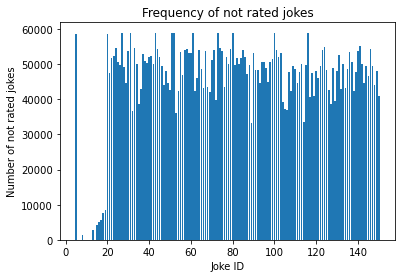

In [47]:
# counting the number of not rated jokes
not_rated_per_joke = matrix.isna().sum(axis=0)

# plotting the frequency of not rated jokes
fig, ax = plt.subplots()
ax.bar(x=not_rated_per_joke.index, height=not_rated_per_joke.values)
ax.set_xlabel('Joke ID')
ax.set_ylabel('Number of not rated jokes')
ax.set_title('Frequency of not rated jokes')
plt.show()


The graph above depicts the number of items with missing values. Notably, jokes numbered approximately 7 to 20 exhibit a relatively low number of missing values. This observation aligns with the findings from Graph 4, which illustrated that these particular jokes have received the highest number of ratings. Conversely, other jokes in the dataset tend to have a higher incidence of missing values. Additionaly, an interesting patter can be seen where there is a drop in missing values approx. every ten jokes. 

Now that the sparsity of the matrix has been checked the nulls will be filled with 0

In [48]:
# filling the nulls with 0
matrix.fillna(0, inplace=True)
matrix

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
1,0.22,-9.28,-9.28,-6.78,0.88,-9.66,-9.03,-7.47,-8.72,-9.16,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-9.69,9.94,9.53,9.94,0.41,3.72,9.66,-2.69,-9.56,-9.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-9.84,-9.84,-7.22,-2.03,-9.94,-9.97,-9.88,-9.81,-9.78,-6.84,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-5.81,-4.50,-4.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,6.91,4.75,-5.91,-0.41,-4.03,3.88,6.22,5.66,6.09,5.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63974,0.00,-4.44,1.53,-1.44,-9.16,-7.44,2.25,3.75,5.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63975,0.00,0.62,4.53,4.97,-3.38,-8.25,-7.78,-9.19,1.50,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63976,0.00,-7.25,4.56,-5.59,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


------------------

# RecSys: SVD

First the matrix needs to be split into train (to train the system), test (to evaluate the final predictions). For SVD 20% of rows will be allocated to the test set and 80% to train.

In [49]:
## splitting the dataset

# calculating 20% of rows 
rows_20_percent = int(0.2 * len(matrix))
print('20% of total rows:', rows_20_percent)

# shuffiling the rows of the matrix
matrix_shuffled = matrix.sample(frac=1, random_state=42)

# extracting the test set
test = matrix_shuffled.iloc[:rows_20_percent, :].copy() # first 20% of rows and all columns
print('shape of the test set:', test.shape)

# extracting the train set
train = matrix_shuffled.iloc[rows_20_percent:, :].copy() # last 80% of rows and all columns
print('shape of the train set:', train.shape)


20% of total rows: 11826
shape of the test set: (11826, 140)
shape of the train set: (47306, 140)


Double checking if the split was done correctly

In [50]:
test.head()

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
1783,0.00,-9.59,-1.38,-9.78,-1.56,-9.97,9.97,-9.81,9.94,0.00,...,-9.81,9.97,0.00,0.00,9.97,0.00,0.00,0.00,9.94,0.00
8048,0.00,8.00,4.59,4.53,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63051,0.00,-9.75,-3.97,-9.78,2.28,9.88,9.94,-9.78,2.34,0.00,...,0.00,-9.53,0.00,0.00,0.00,0.00,0.00,-9.53,0.00,0.00
36205,0.00,-8.50,1.03,-1.72,4.25,-8.47,2.53,4.25,2.19,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
37168,0.00,-6.31,-7.31,-8.12,-9.69,4.62,6.34,8.41,4.50,0.00,...,0.00,1.00,1.78,0.00,-7.44,0.00,-4.88,-5.19,0.00,4.41


In [51]:
matrix_shuffled.head()

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
1783,0.00,-9.59,-1.38,-9.78,-1.56,-9.97,9.97,-9.81,9.94,0.00,...,-9.81,9.97,0.00,0.00,9.97,0.00,0.00,0.00,9.94,0.00
8048,0.00,8.00,4.59,4.53,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63051,0.00,-9.75,-3.97,-9.78,2.28,9.88,9.94,-9.78,2.34,0.00,...,0.00,-9.53,0.00,0.00,0.00,0.00,0.00,-9.53,0.00,0.00
36205,0.00,-8.50,1.03,-1.72,4.25,-8.47,2.53,4.25,2.19,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
37168,0.00,-6.31,-7.31,-8.12,-9.69,4.62,6.34,8.41,4.50,0.00,...,0.00,1.00,1.78,0.00,-7.44,0.00,-4.88,-5.19,0.00,4.41


The above shuffled matrix and test matrix have the same first 5 rows which means the split was done correctly

## latent factor

By default svds package takes 6 as the latent factor. This is the hyperparameter of SVD. The optimal latent factor needs to found to make sure the most precise predictions are made. To do so the train matrix will be used. 5 different latent factors will be tested (6(default), 12, 18, 24, 30)

Steps for each latent factor:
1. take out 100 users of the matrix and store it (this is the y)
2. find the 3 matrices (U, sigma, Vt) from x (train matrix)
3. calculate the dot product between U and sigma and Vt to get the matrix back (x_hat)
4. take out the predicted ratings of the 100 users taken out before (y_hat)
5. calculate the RMSE using y and y_hat
<br>
Repeat this process with another set of 100 users (total 20 times)

In [52]:
# finding all unique userIds and storing in a list 
user_ids = train.index.unique().tolist()

In [53]:
#  randomly selectings 100 users ids from user_ids list 
y_1_user_ids = random.sample(list(user_ids), 100)
# extracting the corresponding rows from train matrix
y_1 = train.loc[y_1_user_ids]

y_1

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
57679,0.00,-3.69,-4.31,1.31,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
36056,0.00,2.16,-6.53,-6.88,-4.22,-6.84,-0.81,-1.25,0.22,0.00,...,0.00,-3.69,-3.44,-1.66,-2.66,-2.53,-0.72,-0.41,1.16,0.75
36590,0.00,-6.59,0.50,0.41,-0.47,4.62,-7.16,-9.75,-9.84,0.00,...,0.00,-8.31,-8.50,-6.78,-9.09,0.00,-9.72,-6.50,0.94,-8.44
46335,0.00,-4.56,-7.34,-8.00,-7.50,-9.34,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43959,0.00,-4.28,3.66,1.59,1.09,-5.66,3.66,5.75,6.75,0.00,...,-6.41,7.41,8.06,2.31,6.72,8.66,8.09,7.31,6.69,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51520,0.00,-6.25,-6.19,-3.28,-7.00,-6.62,-6.62,-6.62,-6.66,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30596,0.00,0.53,6.62,3.78,-0.22,-3.06,1.41,1.62,6.50,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
41824,0.00,-3.09,0.12,-3.59,0.53,1.91,-2.41,0.12,-2.69,0.00,...,-1.72,0.91,2.22,-2.41,-0.72,-2.78,0.12,0.03,0.06,1.59


In [54]:
# finding the 3 matrices out using the default latent factor (=6)
U, sigma, Vt = svds(train) 

In [55]:
# transforming sigma to a diagonal matrix
sigma = np.diag(sigma)
# getting the predicted ratings by calculating back the matrix from U, sigma and Vt
X_hat = U.dot(sigma.dot(Vt))
# creating a df of the results - recalculated matrix with the predicted ratings 
X_hat = pd.DataFrame(X_hat, index = train.index, columns = train.columns)

In [56]:
# storing the predicted results of the 100 users
y_hat = X_hat.loc[X_hat.index.isin(y_1_user_ids)]

y_hat

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
62013,-0.02,6.52,0.43,-8.70,-4.09,-2.84,0.74,1.84,2.57,-0.01,...,-1.49,0.21,3.55,1.10,2.33,-0.61,1.51,4.42,1.95,5.15
38824,0.00,-0.99,1.28,2.05,-6.76,-9.64,7.21,-3.36,3.89,0.00,...,-0.09,1.52,0.95,0.05,1.18,0.09,-0.09,0.68,0.49,-0.28
32708,-0.01,-0.30,-0.36,-1.91,-3.29,-2.42,4.64,0.36,3.60,0.01,...,-0.11,0.60,0.46,-0.19,0.47,-0.07,-0.12,0.23,0.10,-0.21
20084,0.03,7.53,2.58,-1.22,0.13,-0.32,0.20,0.10,-0.19,0.01,...,0.07,-0.13,-0.11,0.03,-0.10,0.02,-0.04,0.02,-0.00,0.09
55390,-0.01,2.34,-0.35,-0.72,-4.24,-8.23,-5.21,-6.92,-6.25,-0.07,...,-1.07,-2.77,-2.98,-2.32,-2.81,-1.81,-2.78,-2.91,-2.81,-2.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61410,0.00,-1.96,1.50,4.01,-0.92,-2.34,4.61,-0.11,3.05,0.01,...,-0.18,0.47,0.12,-0.31,0.20,-0.22,-0.40,-0.11,-0.18,-0.46
28473,0.00,0.68,0.63,0.36,-1.09,-1.46,1.89,-0.28,1.16,0.00,...,0.01,0.26,0.07,-0.07,0.13,-0.01,-0.11,-0.01,-0.00,-0.21
43354,-0.08,-5.43,-5.50,-10.25,-5.43,-2.52,-1.91,1.00,1.22,-0.03,...,-1.29,0.74,4.18,1.64,2.95,-0.15,2.27,4.96,2.59,5.53


In [57]:
# calculating the rmse
rmse_1 = np.sqrt(mean_squared_error(y_1, y_hat))
print("Mean squared error with k=6: ", rmse_1)

Mean squared error with k=6:  2.8689908525567245


Now the above needs to be done 19 more times and then the average rmse will be calculated

In [58]:
## calcluating the average RMSE for the defaul latent factor 

# setting the nr of interactions
num_interactions = 20

# initializing the rmse list
rmse_list = []

for i in range(num_interactions):
    #  randomly selectings 100 users ids from user_ids list
    y_1_user_ids = random.sample(list(user_ids), 100)
    # extracting the corresponding rows from train matrix
    y_1 = train.loc[y_1_user_ids]

    # finding the 3 matrices out using the default latent factor (=6)
    U, sigma, Vt = svds(train, k=6) 

    # transforming sigma to a diagonal matrix
    sigma = np.diag(sigma)
    # getting the predicted ratings by calculating back the matrix from U, sigma and Vt
    X_hat = U.dot(sigma.dot(Vt))
    # creating a df of the results - recalculated matrix with the predicted ratings 
    X_hat = pd.DataFrame(X_hat, index = train.index, columns = train.columns)

    # storing the predicted results of the 100 users
    y_hat = X_hat.loc[X_hat.index.isin(y_1_user_ids)]

    # calculating the rmse
    rmse = np.sqrt(mean_squared_error(y_1, y_hat))
    rmse_list.append(rmse)

# calculating the average rmse for latent factor 6
avg_rmse_6 = sum(rmse_list) / len(rmse_list)
print("Average RMSE with k=6: ", avg_rmse_6)


Average RMSE with k=6:  2.9125180654915033


Now the above will be repeated with different latent factor values 

In [59]:
## calcluating the average RMSE for latent factor = 12

# setting the nr of interactions
num_interactions = 20

# initializing the rmse list
rmse_list = []

for i in range(num_interactions):
    #  randomly selectings 100 users ids from user_ids list
    y_1_user_ids = random.sample(list(user_ids), 100)
    # extracting the corresponding rows from train matrix
    y_1 = train.loc[y_1_user_ids]

    # finding the 3 matrices out using latent factor = 12)
    U, sigma, Vt = svds(train, k=12) 

    # transforming sigma to a diagonal matrix
    sigma = np.diag(sigma)
    # getting the predicted ratings by calculating back the matrix from U, sigma and Vt
    X_hat = U.dot(sigma.dot(Vt))
    # creating a df of the results - recalculated matrix with the predicted ratings 
    X_hat = pd.DataFrame(X_hat, index = train.index, columns = train.columns)

    # storing the predicted results of the 100 users
    y_hat = X_hat.loc[X_hat.index.isin(y_1_user_ids)]

    # calculating the rmse
    rmse = np.sqrt(mean_squared_error(y_1, y_hat))
    rmse_list.append(rmse)

# calculating the average rmse for latent factor 12
avg_rmse_12 = sum(rmse_list) / len(rmse_list)
print("Average RMSE with k=12: ", avg_rmse_12)

Average RMSE with k=12:  3.0947630879186008


In [60]:
## calcluating the average RMSE for latent factor = 18

# setting the nr of interactions
num_interactions = 20

# initializing the rmse list
rmse_list = []

for i in range(num_interactions):
    #  randomly selectings 100 users ids from user_ids list
    y_1_user_ids = random.sample(list(user_ids), 100)
    # extracting the corresponding rows from train matrix
    y_1 = train.loc[y_1_user_ids]

    # finding the 3 matrices out using latent factor = 18)
    U, sigma, Vt = svds(train, k = 18) 

    # transforming sigma to a diagonal matrix
    sigma = np.diag(sigma)
    # getting the predicted ratings by calculating back the matrix from U, sigma and Vt
    X_hat = U.dot(sigma.dot(Vt))
    # creating a df of the results - recalculated matrix with the predicted ratings 
    X_hat = pd.DataFrame(X_hat, index = train.index, columns = train.columns)

    # storing the predicted results of the 100 users
    y_hat = X_hat.loc[X_hat.index.isin(y_1_user_ids)]

    # calculating the rmse
    rmse = np.sqrt(mean_squared_error(y_1, y_hat))
    rmse_list.append(rmse)

# calculating the average rmse for latent factor 18
avg_rmse_18 = sum(rmse_list) / len(rmse_list)
print("Average RMSE with k=18: ", avg_rmse_18)

Average RMSE with k=18:  3.0380556780194654


In [61]:
## calcluating the average RMSE for latent factor = 24

# setting the nr of interactions
num_interactions = 20

# initializing the rmse list
rmse_list = []

for i in range(num_interactions):
    #  randomly selectings 100 users ids from user_ids list
    y_1_user_ids = random.sample(list(user_ids), 100)
    # extracting the corresponding rows from train matrix
    y_1 = train.loc[y_1_user_ids]

    # finding the 3 matrices out using latent factor = 24)
    U, sigma, Vt = svds(train, k=24) 

    # transforming sigma to a diagonal matrix
    sigma = np.diag(sigma)
    # getting the predicted ratings by calculating back the matrix from U, sigma and Vt
    X_hat = U.dot(sigma.dot(Vt))
    # creating a df of the results - recalculated matrix with the predicted ratings 
    X_hat = pd.DataFrame(X_hat, index = train.index, columns = train.columns)

    # storing the predicted results of the 100 users
    y_hat = X_hat.loc[X_hat.index.isin(y_1_user_ids)]

    # calculating the rmse
    rmse = np.sqrt(mean_squared_error(y_1, y_hat))
    rmse_list.append(rmse)

# calculating the average rmse for latent factor 24
avg_rmse_24 = sum(rmse_list) / len(rmse_list)
print("Average RMSE with k=24: ", avg_rmse_24)

Average RMSE with k=24:  3.2113039347926593


In [62]:
## calcluating the average RMSE for latent factor = 30

# setting the nr of interactions
num_interactions = 20

# initializing the rmse list
rmse_list = []

for i in range(num_interactions):
    #  randomly selectings 100 users ids from user_ids list
    y_1_user_ids = random.sample(list(user_ids), 100)
    # extracting the corresponding rows from train matrix
    y_1 = train.loc[y_1_user_ids]

    # finding the 3 matrices out using latent factor = 30)
    U, sigma, Vt = svds(train, k=30) 

    # transforming sigma to a diagonal matrix
    sigma = np.diag(sigma)
    # getting the predicted ratings by calculating back the matrix from U, sigma and Vt
    X_hat = U.dot(sigma.dot(Vt))
    # creating a df of the results - recalculated matrix with the predicted ratings 
    X_hat = pd.DataFrame(X_hat, index = train.index, columns = train.columns)

    # storing the predicted results of the 100 users
    y_hat = X_hat.loc[X_hat.index.isin(y_1_user_ids)]

    # calculating the rmse
    rmse = np.sqrt(mean_squared_error(y_1, y_hat))
    rmse_list.append(rmse)

# calculating the average rmse for latent factor 30
avg_rmse_30 = sum(rmse_list) / len(rmse_list)
print("Average RMSE with k=30: ", avg_rmse_30)

Average RMSE with k=30:  3.1572876881459733


The average root mean square error (RMSE) values for each value of k have been computed. To facilitate further analysis, these values will be stored in a dictionary. The purpose of storing them in a dictionary is to identify the k value that corresponds to the smallest average RMSE.

In [63]:
# creating a dictionary to store all average rmse values
rmse_dict_svd = {6: avg_rmse_6, 12: avg_rmse_12, 18: avg_rmse_18, 24: avg_rmse_24, 30: avg_rmse_30}
# finding the lowesr average rmse
min_rmse_name = min(rmse_dict_svd, key=rmse_dict_svd.get)
print(f"The latent factor with the smallest average RMSE is {min_rmse_name} with a value of {rmse_dict_svd[min_rmse_name]}")

The latent factor with the smallest average RMSE is 6 with a value of 2.9125180654915033


Now that the optimal latent factor is found it will be used to make the final prediction to find top 5 most similar jokes to a specified joke. 

In [64]:
# getting out the 3 matrices using the best latent factor identified above
U, sigma, Vt = svds(train, k=min_rmse_name)

In [65]:
## finding the most similar items to a specified item, code inspired from https://machinelearningmastery.com/using-singular-value-decomposition-to-build-a-recommender-system/ 

# calculating the cosine similarity between two vectors
def cosine_similarity(V, U):
    return (V @ U) / (np.linalg.norm(V) * np.linalg.norm(U))

# specifying the nr of similar items we want to see
num_similar = 5

# finding the most similar items to the input item based on the latent factors in Vt
def find_similar_items(item_id, Vt, num_similar):
    similarities = []
    # calculating the cosine similarity between the input item and all other items
    for col in range(Vt.shape[1]):
        # exclude the input item from the results
        if col != item_id: 
            similarity = cosine_similarity(Vt[:, item_id], Vt[:, col])
            similarities.append((col, similarity))
    # sorting the similarities in descending order and return the most similar items
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:num_similar]

# spcifying the item we want to find the most similar ones to - this is the picked item 
item_id = 0 

# finding the most similar items
similar_items = find_similar_items(item_id, Vt, num_similar)
print(f"The {num_similar} most similar jokes to joke {item_id} are:")

for j_id, similarity in similar_items:
    print(f"joke {j_id} with similarity {similarity}")

The 5 most similar jokes to joke 0 are:
joke 2 with similarity 0.8116643771740683
joke 1 with similarity 0.7939595938812365
joke 9 with similarity 0.5009510651221221
joke 113 with similarity 0.46368092275407424
joke 47 with similarity 0.4581675999830554


------------

# RecSys: KNN

First the test matrix created above will be split fursther into validation (50% rows of test) and test (50% rows of test).

In [66]:
test_20 = test

## splitting the test_20 set into test and valid

# calcluating 50% of rows
rows_50_percent = int(len(test_20)/2)
print('50% of total rows:', rows_50_percent)

# extracting the test set
test = test_20.iloc[:rows_50_percent, :].copy() # first 50% of rows and all columns
print('shape of the test set:', test.shape)

# extracting the valid set
valid = test_20.iloc[rows_50_percent:, :].copy() # last 50% of rows and all columns
print('shape of the valid set:', valid.shape)

50% of total rows: 5913
shape of the test set: (5913, 140)
shape of the valid set: (5913, 140)


KNN will be applied to predict how a user might fell about an item it hasn't interacted with based on ratings similar users gave. First predictions will be made using cosine similarity and k=3

Steps to do execute KNN by hand:
1. creating the user-user similarity matrix
2. finding k closest neighbors to a specified user
3. find ratings the k closest neighbors gave to items and calculate the mean 



In [67]:
from sklearn.metrics.pairwise import cosine_similarity

# finding the similarities between all users on the train matrix, code inspired from DataCamp
similarities_user_train = cosine_similarity(train)

In [68]:
# storing the above similarities in a dataframe, code inspired from DataCamp
user_cosine_similarity_train = pd.DataFrame(similarities_user_train, index=train.index, columns=train.index)
user_cosine_similarity_train.head()

userId,58829,26492,31774,8211,38341,24162,42680,58786,42175,62061,...,18424,6903,59360,12382,48027,58760,41036,947,17345,61036
userId,,,,,,,,,,,,,,,,,,,,,
58829,1.00,-0.01,0.28,0.02,0.09,0.12,-0.17,0.12,-0.43,0.37,...,0.39,0.15,0.19,0.28,0.15,0.08,-0.06,0.02,0.07,-0.09
26492,-0.01,1.00,0.17,0.75,0.38,-0.58,-0.00,-0.04,0.29,0.26,...,-0.36,0.17,-0.10,-0.19,-0.06,0.48,-0.60,0.08,0.10,-0.20
31774,0.28,0.17,1.00,-0.10,0.13,-0.10,0.14,-0.04,-0.16,0.27,...,-0.01,-0.00,0.15,0.41,0.18,0.20,0.00,0.16,0.12,0.00
8211,0.02,0.75,-0.10,1.00,0.36,-0.44,-0.02,0.15,0.36,0.12,...,-0.16,0.22,-0.03,-0.05,0.03,0.60,-0.45,0.06,0.03,-0.30
38341,0.09,0.38,0.13,0.36,1.00,-0.22,-0.01,0.21,0.12,0.22,...,0.08,0.32,0.20,0.09,0.12,0.30,-0.17,-0.10,0.05,-0.11


The above seems to be correct as similarities between the user itself is equal to 1. Now we can find most similar user to a specified user.

In [69]:
# finding the similarity values for a specific user, in this case user 10, code inspired from DataCamp
cosine_similarity_series = user_cosine_similarity_train.loc[10]
cosine_similarity_series

userId
58829    0.44
26492   -0.21
31774    0.13
8211    -0.06
38341    0.05
         ... 
58760   -0.02
41036    0.13
947      0.01
17345    0.22
61036    0.02
Name: 10, Length: 47306, dtype: float64

In [70]:
# sorting the values from highest to lowest, so for the 3 highest neighbors the rating will be calculated, code inspired from DataCamp
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
ordered_similarities

userId
10       1.00
57039    0.52
63044    0.52
17444    0.52
51376    0.52
         ... 
49684   -0.44
52981   -0.45
56702   -0.46
58127   -0.47
45858   -0.49
Name: 10, Length: 47306, dtype: float64

In [71]:
# finding 3 most similar users (k=3), code inspired from DataCamp
nearest_neighbors = ordered_similarities[1:4].index

# finding the ratings the 3 closes neighbors gave
neighbor_ratings = matrix.reindex(nearest_neighbors)

neighbor_ratings

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
57039,0.00,-5.12,0.16,9.94,3.50,-6.69,9.06,-5.19,3.41,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63044,0.00,-5.16,-5.91,7.66,-4.91,-4.78,4.91,-4.38,7.34,0.00,...,0.00,8.62,8.72,0.00,7.88,0.00,0.00,7.94,8.47,8.00
17444,0.00,6.03,5.34,-6.25,2.47,-6.78,5.91,-3.16,-1.75,0.00,...,0.00,0.00,0.00,0.00,9.47,0.00,0.00,9.44,0.00,5.50


In [72]:
# calcluating the mean of closest neighbor ratings and sorting from highest to lowest, code inspired from DataCamp
predicted_ratings = neighbor_ratings.mean().sort_values(ascending=False)

In [73]:
print('items recommender to user 10 in order:', predicted_ratings)
print('nearest neighbors on which the prediction was based on:', nearest_neighbors)

items recommender to user 10 in order: jokeId
63    8.55
50    8.24
53    8.21
62    8.13
89    8.04
      ... 
7    -1.42
29   -1.78
23   -2.34
18   -4.24
16   -6.08
Length: 140, dtype: float64
nearest neighbors on which the prediction was based on: Int64Index([57039, 63044, 17444], dtype='int64', name='userId')


This is how a prediction is made for one specific user. Now all user ratings will be predictied using the same steps except looping through all user ids in train matrix and storing the ratings in all_user_predictions.

In [74]:
# storing the user ids in the train set 
train_user_ids = train.index.unique().tolist()

In [75]:
## creating a function to make recommendations for any user

def make_recommendations(user_id, train_data, user_similarity_data, num_neighbors, num_recommendations):
    # finding the similarity values for all users
    cosine_similarity_series = user_similarity_data.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

    # finding k most similar users
    nearest_neighbors = ordered_similarities[1:num_neighbors+1].index

    # finding the ratings of the k closest neighbors
    neighbor_ratings = train_data.reindex(nearest_neighbors)
    
    # calculating the mean of the ratings of k closest neighbors
    predicted_ratings = neighbor_ratings.mean().sort_values(ascending=False)[:num_recommendations]

    return predicted_ratings

And to find recommendations for a specific user:

In [76]:
## finding recommendations for a specific user

user_id = 10
num_neighbors = 3
num_recommendations = 5
predicted_ratings = make_recommendations(user_id, train, user_cosine_similarity_train, num_neighbors, num_recommendations)

print('Items recommended to user {} in order:'.format(user_id))
print(predicted_ratings)


Items recommended to user 10 in order:
jokeId
63   8.55
50   8.24
53   8.21
62   8.13
89   8.04
dtype: float64


The above tells us that the knn recommender system would recommend jokes 63, 50, 53, 62, 89 to user 10. The predictions are based on users 52872, 36682, 22653

## Valid

Above the train set was used to give some item predictions to a specific user using the cosine similarity distance measure and basing the prediction on 3 nearest neighbors. Now the valid set will be used to find the optimal nr of nearest neighbors and which measure distannce yields the best predictions. RMSE will be calculated using k = 5, 10, 20, 40 and with cosine or euclidean distance. 

Steps (for one k and one distance measure):
1. two items will be taken out of the matrix and stored in another matrix (y)
2. predictions will be created using the same logic as above but only for the items taken out in y (y_hat)
3. RMSE will be calculated using y and y_hat
<br>
(ideally these steps could be repeated using two other items and calcluating the average RMSE, however, this wasn't possible now because of time constrains of the project)

At the end the k value and distance with the lowest RMSE will be taken.


In [77]:
# finding the similarities between all users on the valid matrix using the cosine distance
similarities_user_valid_cosine = cosine_similarity(valid)
# transforming into a dataframe
user_cosine_similarity_valid = pd.DataFrame(similarities_user_valid_cosine, index=valid.index, columns=valid.index)
user_cosine_similarity_valid.head()

userId,40470,12717,43541,54313,49565,4784,50262,10968,44198,16469,...,23291,15909,6848,11042,8949,3686,18807,10202,47540,21122
userId,,,,,,,,,,,,,,,,,,,,,
40470,1.00,0.36,0.24,-0.12,-0.11,0.28,0.48,0.23,-0.13,-0.06,...,0.08,0.47,0.16,0.19,-0.04,-0.07,-0.37,-0.16,0.08,0.27
12717,0.36,1.00,0.41,-0.54,-0.17,0.24,0.63,0.11,-0.31,-0.11,...,0.20,0.26,0.25,0.30,-0.29,-0.05,-0.35,-0.23,0.09,0.24
43541,0.24,0.41,1.00,-0.32,-0.08,0.33,0.46,0.05,-0.06,-0.12,...,0.06,0.24,0.21,0.24,-0.22,0.08,-0.32,-0.02,0.13,0.08
54313,-0.12,-0.54,-0.32,1.00,0.46,-0.25,-0.49,0.09,0.46,0.03,...,-0.23,0.04,-0.26,-0.34,0.47,0.05,0.29,0.04,-0.16,0.03
49565,-0.11,-0.17,-0.08,0.46,1.00,-0.36,-0.33,0.08,0.70,0.00,...,-0.41,0.06,-0.13,-0.28,0.52,-0.18,0.19,-0.15,0.10,0.00


In [78]:
# finding the similarities between all users on the valid matrix using the euclidean distance
similarities_user_valid_euclidean = euclidean_distances(valid)
# converting the distance matrix to a similarity matrix, the idea is that the similarity between two points is high when their distance is low and vice versa
similarities_user_valid_euclidean = 1 / (1 + similarities_user_valid_euclidean)
# transforming into a dataframe
user_euclidean_distance_valid = pd.DataFrame(similarities_user_valid_euclidean, index=valid.index, columns=valid.index)
user_euclidean_distance_valid.head()

userId,40470,12717,43541,54313,49565,4784,50262,10968,44198,16469,...,23291,15909,6848,11042,8949,3686,18807,10202,47540,21122
userId,,,,,,,,,,,,,,,,,,,,,
40470,1.00,0.03,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02,...,0.02,0.01,0.02,0.02,0.02,0.02,0.01,0.02,0.02,0.03
12717,0.03,1.00,0.03,0.02,0.03,0.03,0.05,0.03,0.03,0.03,...,0.04,0.01,0.02,0.02,0.02,0.02,0.01,0.03,0.03,0.03
43541,0.02,0.03,1.00,0.02,0.03,0.03,0.04,0.03,0.03,0.03,...,0.03,0.01,0.02,0.02,0.02,0.02,0.01,0.03,0.03,0.03
54313,0.02,0.02,0.02,1.00,0.05,0.02,0.03,0.03,0.04,0.03,...,0.04,0.01,0.02,0.02,0.04,0.02,0.01,0.03,0.03,0.03
49565,0.02,0.03,0.03,0.05,1.00,0.02,0.04,0.04,0.07,0.04,...,0.05,0.01,0.02,0.02,0.05,0.02,0.01,0.03,0.04,0.04


In [79]:
# taking out items 7 and 15 and storing in y
y = valid[[7, 15]].copy()

# storing the user ids that have ranked both jokes 7 and 15 to a list
valid_user_ids = y.index.unique().tolist()

In [80]:
## getting the prediction with 20 nearest neighbors and cosine distance 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_20_cosine = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users
    cosine_similarity_series = user_cosine_similarity_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

    # finding 20 most similar users (k=20)
    nearest_neighbors = ordered_similarities[1:21].index

    # finding the ratings the 20 closest neighbors gave and calculating the mean
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean().sort_values(ascending=False)

    # storing the predicted rating for the current user in the predicted_rankings_valid_20 dictionary
    y_hat_valid_20_cosine[user_id] = predicted_rating


In [81]:
# transforming the dictionary into a df
y_hat_valid_20_cosine = pd.DataFrame(y_hat_valid_20_cosine, index=valid.columns, columns=valid.index).copy()
# transposing the matrix to match y
y_hat_valid_20_cosine = y_hat_valid_20_cosine.T

# extracting only predictions for items 7 and 15
y_hat_valid_20_cosine = y_hat_valid_20_cosine[[7,15]].copy()
y_hat_valid_20_cosine

jokeId,7,15
userId,,
40470,0.07,-1.31
12717,6.18,6.78
43541,6.08,6.02
54313,-7.73,-5.29
49565,-6.22,1.25
...,...,...
3686,-1.47,-3.09
18807,-7.68,-8.39
10202,-0.96,-4.10


In [82]:
# getting the rows of the 20 closest neighbors 
valid.loc[nearest_neighbors, [7,15]]

jokeId,7,15
userId,,
46918,2.25,6.06
11577,1.62,5.28
58903,8.66,4.56
61535,4.84,8.69
58893,4.50,3.78
25407,6.97,6.38
28079,1.16,3.34
20220,1.41,4.00
46711,1.81,0.19


In [83]:
# calculating the rmse
rmse_20_cosine = np.sqrt(mean_squared_error(y, y_hat_valid_20_cosine))
print("Root mean squared error with k=20 and cosine similarity: ", rmse_20_cosine)

Root mean squared error with k=20 and cosine similarity:  2.623369418115667


In [84]:
## getting the prediction with 20 nearest neighbors and euclidean distance 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_20_euclidean = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users 
    euclidean_similarity_series = user_euclidean_distance_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = euclidean_similarity_series.sort_values(ascending=False)

    # finding 20 most similar users (k=20)
    nearest_neighbors = ordered_similarities[1:21].index

    # finding the ratings the 20 closest neighbors gave and calculating the mean
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean().sort_values(ascending=False)

    # storing the predicted rating for the current user in the predicted_rankings_valid_20 dictionary
    y_hat_valid_20_euclidean[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat_valid_20_euclidean = pd.DataFrame(y_hat_valid_20_euclidean, index=valid.columns, columns=valid.index)
# transposing the matrix to match y
y_hat_valid_20_euclidean = y_hat_valid_20_euclidean.T
# extracting only predictions for items 7 and 15
y_hat_valid_20_euclidean = y_hat_valid_20_euclidean[[7,15]].copy()

# calculating the rmse
rmse_20_euclidean = np.sqrt(mean_squared_error(y, y_hat_valid_20_euclidean))
print("Root mean squared error with k=20 and euclidean similarity: ", rmse_20_euclidean)

Root mean squared error with k=20 and euclidean similarity:  2.3661257536571667


In [85]:
## getting the prediction with 5 nearest neighbors and cosine similarity 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_5_cosine = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users
    cosine_similarity_series = user_cosine_similarity_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

    # finding 5 most similar users (k=5)
    nearest_neighbors = ordered_similarities[1:6].index

    # finding the ratings the 5 closest neighbors gave
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean()

    # storing the predicted rating for the current user in the predicted_rankings_valid_5 dictionary
    y_hat_valid_5_cosine[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat_valid_5_cosine = pd.DataFrame(y_hat_valid_5_cosine)
# transposing the matrix to match actual_ratings
y_hat_valid_5_cosine = y_hat_valid_5_cosine.T
# extracting only predictions for items 7 and 15
y_hat_valid_5_cosine = y_hat_valid_5_cosine[[7,15]].copy()

# calculating the rmse
rmse_5_cosine = np.sqrt(mean_squared_error(y, y_hat_valid_5_cosine))
print("Root mean squared error with k=5 and cosine similarity: ", rmse_5_cosine)

Root mean squared error with k=5 and cosine similarity:  2.74982652564851


In [86]:
## getting the prediction with 5 nearest neighbors and euclidean distance 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_5_euclidean = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users
    euclidean_similarity_series = user_euclidean_distance_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = euclidean_similarity_series.sort_values(ascending=False)

    # finding 5 most similar users (k=5)
    nearest_neighbors = ordered_similarities[1:6].index

    # finding the ratings the 5 closest neighbors gave and calculating the mean
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean().sort_values(ascending=False)

    # storing the predicted rating for the current user in the predicted_rankings_valid_5 dictionary
    y_hat_valid_5_euclidean[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat_valid_5_euclidean = pd.DataFrame(y_hat_valid_5_euclidean, index=valid.columns, columns=valid.index)
# transposing the matrix to match y
y_hat_valid_5_euclidean = y_hat_valid_5_euclidean.T
# extracting only predictions for items 7 and 15
y_hat_valid_5_euclidean = y_hat_valid_5_euclidean[[7,15]].copy()

# calculating the rmse
rmse_5_euclidean = np.sqrt(mean_squared_error(y, y_hat_valid_5_euclidean))
print("Root mean squared error with k=5 and euclidean similarity: ", rmse_5_euclidean)

Root mean squared error with k=5 and euclidean similarity:  2.3549109788702243


In [87]:
## getting the prediction with 10 nearest neighbors and cosine similarity 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_10_cosine = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users 
    cosine_similarity_series = user_cosine_similarity_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

    # finding 10 most similar users (k=10)
    nearest_neighbors = ordered_similarities[1:11].index

    # finding the ratings the 10 closest neighbors gave
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean()

    # storing the predicted rating for the current user in the predicted_rankings_valid_10 dictionary
    y_hat_valid_10_cosine[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat_valid_10_cosine = pd.DataFrame(y_hat_valid_10_cosine)
# transposing the matrix to match actual_ratings
y_hat_valid_10_cosine = y_hat_valid_10_cosine.T
# extracting only predictions for items 7 and 15
y_hat_valid_10_cosine = y_hat_valid_10_cosine[[7,15]].copy()

# calculating the rmse
rmse_10_cosine = np.sqrt(mean_squared_error(y, y_hat_valid_10_cosine))
print("Root mean squared error with k=10 and cosine similarity: ", rmse_10_cosine)

Root mean squared error with k=10 and cosine similarity:  2.6316820610530556


In [88]:
## getting the prediction with 10 nearest neighbors and euclidean distance 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_10_euclidean = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users
    euclidean_similarity_series = user_euclidean_distance_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = euclidean_similarity_series.sort_values(ascending=False)

    # finding 10 most similar users (k=10)
    nearest_neighbors = ordered_similarities[1:11].index

    # finding the ratings the 10 closest neighbors gave and calculating the mean
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean().sort_values(ascending=False)

    # storing the predicted rating for the current user in the predicted_rankings_valid_10 dictionary
    y_hat_valid_10_euclidean[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat_valid_10_euclidean = pd.DataFrame(y_hat_valid_10_euclidean, index=valid.columns, columns=valid.index)
# transposing the matrix to match y
y_hat_valid_10_euclidean = y_hat_valid_10_euclidean.T
# extracting only predictions for items 7 and 15
y_hat_valid_10_euclidean = y_hat_valid_10_euclidean[[7,15]].copy()

# calculating the rmse
rmse_10_euclidean = np.sqrt(mean_squared_error(y, y_hat_valid_10_euclidean))
print("Root mean squared error with k=10 and euclidean similarity: ", rmse_10_euclidean)

Root mean squared error with k=10 and euclidean similarity:  2.3136017201883257


In [89]:
## getting the prediction with 40 nearest neighbors and cosine similarity 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_40_cosine = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users
    cosine_similarity_series = user_cosine_similarity_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

    # finding 40 most similar users (k=40)
    nearest_neighbors = ordered_similarities[1:41].index

    # finding the ratings the 40 closest neighbors gave
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean()

    # storing the predicted rating for the current user in the predicted_rankings_valid_40 dictionary
    y_hat_valid_40_cosine[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat_valid_40_cosine = pd.DataFrame(y_hat_valid_40_cosine)
# transposing the matrix to match actual_ratings
y_hat_valid_40_cosine = y_hat_valid_40_cosine.T
# extracting only predictions for items 7 and 15
y_hat_valid_40_cosine = y_hat_valid_40_cosine[[7,15]].copy()

# calculating the rmse
rmse_40_cosine = np.sqrt(mean_squared_error(y, y_hat_valid_40_cosine))
print("Root mean squared error with k=40 and cosine similarity: ", rmse_40_cosine)

Root mean squared error with k=40 and cosine similarity:  2.669310344517062


In [90]:
## getting the prediction with 40 nearest neighbors and euclidean distance 

# initializing an empty dictionary to store predicted rankings 
y_hat_valid_40_euclidean = {}

# looping over all users in the test_user_ids list
for user_id in valid_user_ids:
    # finding the similarity values for all users 
    euclidean_similarity_series = user_euclidean_distance_valid.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = euclidean_similarity_series.sort_values(ascending=False)

    # finding 40 most similar users (k=40)
    nearest_neighbors = ordered_similarities[1:41].index

    # finding the ratings the 40 closest neighbors gave and calculating the mean
    neighbor_ratings = valid.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean().sort_values(ascending=False)

    # storing the predicted rating for the current user in the predicted_rankings_valid_40 dictionary
    y_hat_valid_40_euclidean[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat_valid_40_euclidean = pd.DataFrame(y_hat_valid_40_euclidean, index=valid.columns, columns=valid.index)
# transposing the matrix to match y
y_hat_valid_40_euclidean = y_hat_valid_40_euclidean.T
# extracting only predictions for items 7 and 15
y_hat_valid_40_euclidean = y_hat_valid_40_euclidean[[7,15]].copy()

# calculating the rmse
rmse_40_euclidean = np.sqrt(mean_squared_error(y, y_hat_valid_40_euclidean))
print("Root mean squared error with k=40 and euclidean similarity: ", rmse_40_euclidean)

Root mean squared error with k=40 and euclidean similarity:  2.468245907471982


In [91]:
mse_dict = {'k=40, distance=euclidean': rmse_40_euclidean, 'k=40, distance=cosine': rmse_40_cosine, 'k=10, distance=euclidean': rmse_10_euclidean, 'k=10, distance=cosine': rmse_10_cosine, 'k=20, distance=euclidean': rmse_20_euclidean, 'k=20, distance=cosine': rmse_20_cosine, 'k=5, distance=euclidean': rmse_5_euclidean, 'k=5, distance=cosine': rmse_5_cosine}
min_mse_name = min(mse_dict, key=mse_dict.get)
print(f"The smallest RMSE value is with {min_mse_name} with a value of {mse_dict[min_mse_name]}")

The smallest RMSE value is with k=10, distance=euclidean with a value of 2.3136017201883257


## Train

Ideally, now the knn model would be fitted using the k and distance measure determined from above, however, it wasn't possible to calculate the user-user similarties using the euclidean distances as it took too much computational power this computer can take and gave a memory error. Therefore, now the best k using cosine similarity needs to be determined.

In [92]:
mse_dict = {'k=40, distance=cosine': rmse_40_cosine, 'k=10, distance=cosine': rmse_10_cosine, 'k=20, distance=cosine': rmse_20_cosine, 'k=5, distance=cosine': rmse_5_cosine}
min_mse_name = min(mse_dict, key=mse_dict.get)
print(f"The smallest RMSE value is with {min_mse_name} with a value of {mse_dict[min_mse_name]}")

The smallest RMSE value is with k=20, distance=cosine with a value of 2.623369418115667


In [93]:
## finding recommendations for a specific user using the cosine similarity 

user_id = 10
num_neighbors = 20
num_recommendations = 5
predicted_ratings = make_recommendations(user_id, train, user_cosine_similarity_train, num_neighbors, num_recommendations)

print('Items recommended to user {} in order:'.format(user_id))
print(predicted_ratings)
print('based on neighbors:', nearest_neighbors)


Items recommended to user 10 in order:
jokeId
62   7.52
50   7.11
89   6.93
32   6.89
63   6.72
dtype: float64
based on neighbors: Int64Index([28079, 46711, 34412, 20220, 11577, 26421, 26212, 23291, 23332,
            50752, 40947, 22948,  3428, 36246, 28256, 19354, 61399, 28315,
            61157, 21310, 48989, 21640, 40542, 41439, 61694, 42851, 17212,
            23641, 51473, 23150, 25878, 21297, 58255, 22418, 21337, 62312,
            11071, 17039, 44679, 11999],
           dtype='int64', name='userId')


## Test

Now to test how accurate the predictions are the model will be fitted on the test matrix and applying the same logic as when finding the bet k value. 

In [94]:
# finding the similarities between all users on the original matrix
similarities_user_test = cosine_similarity(test)

# storing the above similarities in a dataframe, code inspired from DataCamp
user_cosine_similarity_test = pd.DataFrame(similarities_user_test, index=test.index, columns=test.index)
user_cosine_similarity_test.head()

userId,1783,8048,63051,36205,37168,38579,57695,2993,27747,37030,...,15846,23292,7787,36652,19772,34289,4447,34850,45873,38308
userId,,,,,,,,,,,,,,,,,,,,,
1783,1.00,-0.21,0.21,0.25,0.10,0.26,-0.14,0.16,-0.01,0.21,...,-0.22,-0.07,0.20,-0.03,0.16,0.00,-0.09,0.14,0.05,-0.18
8048,-0.21,1.00,-0.27,-0.49,-0.32,-0.64,0.56,0.00,0.02,-0.13,...,0.18,0.23,-0.12,0.16,-0.78,-0.55,0.18,0.05,-0.08,0.25
63051,0.21,-0.27,1.00,0.05,0.14,0.35,-0.04,-0.08,0.08,-0.02,...,0.02,-0.06,0.03,-0.04,0.19,0.05,0.09,0.03,0.04,-0.01
36205,0.25,-0.49,0.05,1.00,0.12,0.12,-0.06,0.12,0.11,0.06,...,-0.23,0.09,0.08,-0.18,0.60,0.25,-0.69,0.13,0.13,-0.02
37168,0.10,-0.32,0.14,0.12,1.00,0.21,0.04,-0.14,0.29,0.17,...,0.08,-0.03,0.27,0.03,0.17,0.05,0.17,0.24,-0.13,-0.17


In [95]:
# taking out items 120 and 88 and storing in y
y = valid[[120, 88]].copy()
# storing the user ids
test_user_ids = test.index.unique().tolist()

In [96]:
## getting the prediction with 20 nearest neighbors and cosine distance 

# initializing an empty dictionary to store predicted rankings 
y_hat = {}

# looping over all users in the test_user_ids list
for user_id in test_user_ids:
    # finding the similarity values for all users
    cosine_similarity_series = user_cosine_similarity_test.loc[user_id]

    # sorting the values from highest to lowest
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

    # finding 20 most similar users (k=20)
    nearest_neighbors = ordered_similarities[1:21].index

    # finding the ratings the 20 closest neighbors gave and calculating the mean
    neighbor_ratings = test.reindex(nearest_neighbors)
    predicted_rating = neighbor_ratings.mean().sort_values(ascending=False)

    # storing the predicted rating for the current user in the predicted_rankings_test_20 dictionary
    y_hat[user_id] = predicted_rating

# transforming the dictionary into a df
y_hat = pd.DataFrame(y_hat, index=test.columns, columns=test.index).copy()
# transposing the matrix to match y
y_hat = y_hat.T

# extracting only predictions for items 120, 88
y_hat = y_hat[[120, 88]].copy()


In [97]:
# calculating the rmse
rmse = np.sqrt(mean_squared_error(y, y_hat))
print("Root mean squared error with k=20 and cosine similarity: ", rmse)

Root mean squared error with k=20 and cosine similarity:  2.891830213857846


----------------------------------------------